In [10]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.append(str(project_root / 'src'))
sys.path.append(str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Aggiungi il percorso corretto al modulo src
project_src_path = Path.cwd().parent / 'src'
sys.path.append(str(project_src_path))

from model.efficient_frontier.markowitz_optimizer import MarkowitzOptimizer
from model.postprocessing.visualizer import Visualizer


INFO:model.efficient_frontier.markowitz_optimizer:Logger configurato per il modulo model.efficient_frontier.markowitz_optimizer


PydanticUserError: Decorators defined with incorrect fields: model.efficient_frontier.markowitz_optimizer.CovarianceConfig:96821890658160.validate_target (use check_fields=False if you're inheriting from the model and intended this)

For further information visit https://errors.pydantic.dev/2.11/u/decorator-missing-field

In [6]:
# Configurazione perscorsi
#DATA_PATH = Path('../data/processed/returns.csv')
DATA_PATH = Path('../data/raw')
OUTPUT_PATH = Path('../results')
OUTPUT_PATH.mkdir(exist_ok=True)

In [7]:
def load_and_preprocess_data(data_path: Path) -> pd.DataFrame:
    """Carica e prepara i dati storici"""
    stocks = ['AAPL', 'GOOGL', 'MSFT',"META", "AMZN", "LMT", "BAESY", "NVS", "JNJ", "XOM", "SHEL", "CNI", "VALE", "SAP"]
    
    # Leggi e combina i CSV
    dfs = []
    for ticker in stocks:
        df = pd.read_csv(
            data_path / f"{ticker}.csv",
            parse_dates=['Date'],
            usecols=['Date', 'Close'],
            index_col='Date'
        )
        df.columns = [ticker]
        dfs.append(df)
    
    combined = pd.concat(dfs, axis=1)
    return combined.ffill().dropna()

prices = load_and_preprocess_data(DATA_PATH)
prices.head(10)

,AAPL,GOOGL,MSFT,META,AMZN,LMT,BAESY,NVS,JNJ,XOM,SHEL,CNI,VALE,SAP
Date,,,,,,,,,,,,,,
2020-01-02,72.716064,68.108376,153.323288,208.795929,94.900497,346.832733,25.622133,78.047142,126.055191,55.137978,48.650620,86.932518,8.732082,125.219994
2020-01-03,72.009125,67.752075,151.414093,207.691162,93.748497,359.312286,25.664137,77.915627,124.595734,54.694698,49.033371,86.383087,8.628207,122.629745
2020-01-06,72.582916,69.557945,151.805496,211.602707,95.143997,358.765228,26.470604,78.441689,124.440308,55.114643,49.644146,86.136803,8.530823,122.831100
2020-01-07,72.241547,69.423592,150.421371,212.060547,95.343002,359.972351,26.126175,77.660812,125.200264,54.663593,49.188095,85.862083,8.589252,122.300232
2020-01-08,73.403648,69.917725,152.817322,214.210419,94.598503,356.958832,26.226982,77.660812,125.182938,53.839237,48.609886,86.866203,8.582760,123.636551
2020-01-09,74.962791,70.651718,154.726501,217.275986,95.052498,360.345764,26.252184,77.899185,125.554306,54.251408,48.601749,87.188293,8.433439,125.512901
2020-01-10,75.132271,71.108025,154.010559,217.037094,94.157997,359.390503,26.134573,77.151184,125.269302,53.769257,48.056122,87.036720,8.420453,125.375587
2020-01-13,76.737419,71.658897,155.862427,220.869049,94.565002,363.897675,26.882240,77.027885,125.821991,54.282520,48.015404,88.486084,8.647682,126.611214
2020-01-14,75.701218,71.189148,154.764709,218.032394,93.472000,361.396667,26.915840,77.578621,126.530113,53.815907,47.982819,89.130234,8.732082,125.622711


Statistiche returns:
              AAPL        GOOGL         MSFT         META         AMZN  \
count  1005.000000  1005.000000  1005.000000  1005.000000  1005.000000   
mean      0.000963     0.000710     0.000883     0.000521     0.000468   
std       0.021137     0.021151     0.020555     0.029944     0.023735   
min      -0.137708    -0.123685    -0.159453    -0.306391    -0.151398   
25%      -0.009169    -0.009654    -0.009491    -0.012414    -0.012234   
50%       0.000988     0.001056     0.000978     0.001138     0.000781   
75%       0.012662     0.011989     0.011953     0.014930     0.013239   
max       0.113157     0.088388     0.132929     0.209307     0.126949   

               LMT        BAESY          NVS          JNJ          XOM  \
count  1005.000000  1005.000000  1005.000000  1005.000000  1005.000000   
mean      0.000233     0.000786     0.000219     0.000178     0.000550   
std       0.017647     0.018884     0.013303     0.012977     0.023458   
min      -0.1365

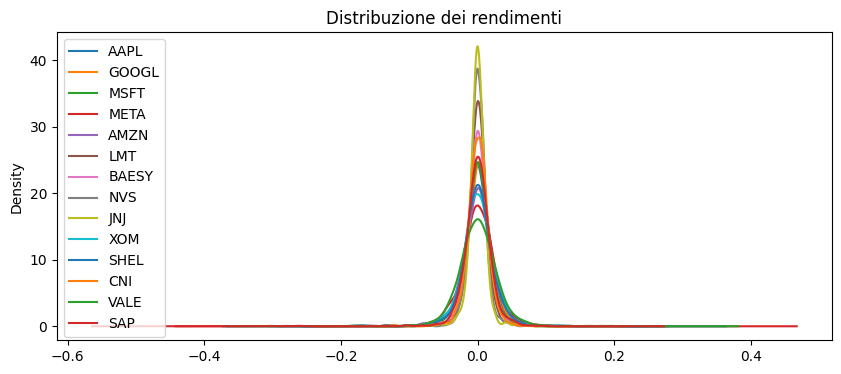

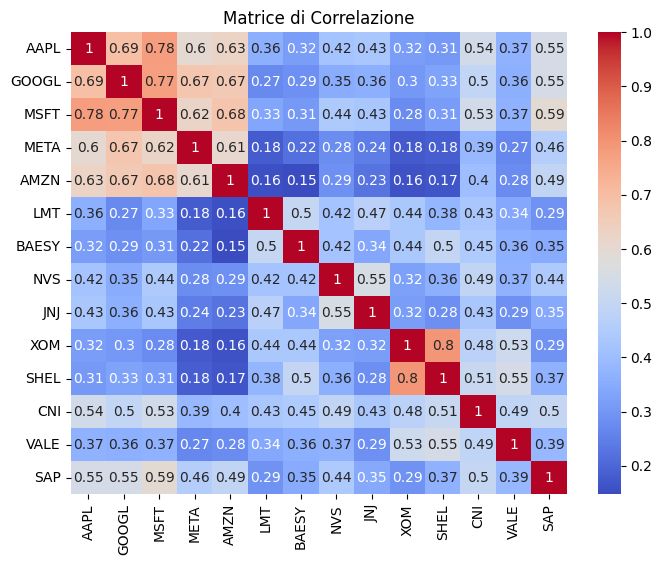

In [8]:
returns = np.log(prices / prices.shift(1)).dropna()
returns.plot(kind='kde', figsize=(10, 4))
plt.title('Distribuzione dei rendimenti')

# Controllo preliminare sui returns
print("Statistiche returns:")
print(returns.describe())
print("\nMedia giornaliera:", returns.mean().round(6))

# Verifica correlazione
corr_matrix = returns.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice di Correlazione');

In [9]:
returns = returns * 100  # Scala i rendimenti per evitare problemi di numeri troppo piccoli
optimizer = MarkowitzOptimizer(returns=returns)
print(optimizer.returns)
frontier = optimizer.efficient_frontier()
print(f"Frontier: {frontier}")
sharpes = optimizer.max_sharpe_ratio()
print(f"Sharpes: {sharpes}")

NameError: name 'MarkowitzOptimizer' is not defined

In [ ]:
viz = Visualizer(optimizer)

# Genera grafici
viz.plot_efficient_frontier(OUTPUT_PATH / 'frontiera_notebook.png')
viz.plot_weights_distribution(
    dict(zip(returns.columns, sharpes['weights'])),
    OUTPUT_PATH / 'allocazione_notebook.png'
)